## Notebook Overview
- Load the enriched cohort, consolidate race groups, and build combined feature matrices.
- Split data into paired configurations (with vs without race) and train ECE-optimized MLPs.
- Evaluate calibration curves and race-specific prediction distributions for each model.
- Iterate multiple reruns to quantify variability, visualize mean shifts, and tabulate p-value heatmaps.
- Explore balancing strategies and random label controls to stress-test fairness conclusions.


In [ ]:
from helper_functions.notebook_utils import BinaryExpectedCalibrationError, MetricsCallback, binary_expected_calibration_error, encode_and_split_new, equate_weights, generate_one_hot, paired_t_test, train_simultaneously, two_sample_t_test, verify_proportions
from helper_functions.testing import encode_and_split


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from keras.optimizers import Adam

import scipy.stats as stats

import keras.backend as K

from helper_functions.nn import create_nn
from helper_functions.nn_training import train_model
from helper_functions.plotting import roc_plot, confusion_matrix_display
from helper_functions.MLP import MLP

from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.initializers import GlorotUniform

from sklearn.calibration import calibration_curve

ImportError: cannot import name 'parse_version' from 'sklearn.utils' (/Users/aidanlicoppe/miniconda3/lib/python3.10/site-packages/sklearn/utils/__init__.py)

In [3]:
merged_df = pd.read_csv('combined_w_age_and_insurance.csv')
merged_df.drop(columns=['Unnamed: 0'], inplace=True)

merged_df

,subject_id,stay_id,hadm_id,intime,outtime,time_of_day,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,gender,race,arrival_transport,chiefcomplaint,disposition,insurance_type,age
0,10000032,32952584,29079034.0,2180-07-22 16:24:00,2180-07-23 05:54:00,16.40,97.8,87.0,14.0,97.0,71.0,43.0,2.0,F,WHITE,AMBULANCE,Hypotension,N,Medicaid,52
1,10000032,33258284,22595853.0,2180-05-06 19:17:00,2180-05-06 23:30:00,19.28,98.4,70.0,16.0,97.0,106.0,63.0,3.0,F,WHITE,AMBULANCE,"Abd pain, Abdominal distention",A,Medicaid,52
2,10000032,35968195,25742920.0,2180-08-05 20:58:00,2180-08-06 01:44:00,20.97,99.4,105.0,18.0,96.0,106.0,57.0,3.0,F,WHITE,AMBULANCE,"n/v/d, Abd pain",A,Medicaid,52
3,10000032,38112554,22841357.0,2180-06-26 15:54:00,2180-06-26 21:31:00,15.90,98.9,88.0,18.0,97.0,116.0,88.0,3.0,F,WHITE,AMBULANCE,Abdominal distention,A,Medicaid,52
4,10000032,39399961,29079034.0,2180-07-23 05:54:00,2180-07-23 14:00:00,5.90,98.7,77.0,16.0,98.0,96.0,50.0,2.0,F,WHITE,AMBULANCE,"Abdominal distention, Abd pain, LETHAGIC",A,Medicaid,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376206,19999784,34149746,25715748.0,2119-08-11 09:15:00,2119-08-11 13:40:00,9.25,98.8,92.0,18.0,100.0,122.0,77.0,3.0,M,BLACK,WALK IN,Wound eval,A,Medicaid,57
376207,19999784,35692999,26194817.0,2119-06-18 14:21:00,2119-06-18 21:09:29,14.35,98.6,80.0,18.0,100.0,161.0,100.0,3.0,M,BLACK,WALK IN,L Leg weakness,A,Medicaid,57
376208,19999784,37972930,24935234.0,2119-07-09 17:38:00,2119-07-10 00:04:00,17.63,98.0,91.0,16.0,99.0,148.0,90.0,2.0,M,BLACK,WALK IN,Abnormal MRI,A,Medicaid,57
376209,19999828,30712109,29734428.0,2147-07-17 17:18:00,2147-07-18 17:34:00,17.30,98.1,83.0,18.0,100.0,107.0,75.0,2.0,F,WHITE,WALK IN,"Abd pain, Wound eval",A,Medicaid,46


In [4]:
frequent_races = ['WHITE', 'BLACK', 'HISPANIC', 'ASIAN']

# Update 'race' column
merged_df.loc[~merged_df['race'].isin(frequent_races), 'race'] = 'OTHER'

columns = merged_df.columns

numerical_columns = list(merged_df.columns[5:13])
numerical_columns.append('age')

for column in numerical_columns:
    scaler = MinMaxScaler()
    values = merged_df[column].values.reshape(-1, 1)
    merged_df[column] = scaler.fit_transform(values)
    
copy = merged_df.copy()

categorical_columns = ['gender', 'arrival_transport', 'race']
numeric_values = copy[numerical_columns].values
categorical_values = copy[categorical_columns]

encoder = OneHotEncoder()

# Fit the OneHotEncoder with the categorical values
encoder.fit(categorical_values)

categorical_values = encoder.transform(categorical_values).toarray()

X_num_cat = np.concatenate((numeric_values, categorical_values), axis=1)

disposition_column = merged_df['disposition'].values

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder and transform the 'disposition' column
Y_encoded = label_encoder.fit_transform(disposition_column)
Y = (1 - Y_encoded)

text = merged_df['chiefcomplaint'].values

# Combining text data with numerical data for training and testing
string_array_reshaped = text.reshape(-1, 1)
X_combined = np.concatenate((string_array_reshaped, X_num_cat), axis=1)

races = ['ASIAN', 'BLACK', 'HISPANIC', 'OTHER', 'WHITE']

In [6]:
encoder.get_feature_names_out(['gender', 'arrival_transport', 'race'])

array(['gender_F', 'gender_M', 'arrival_transport_AMBULANCE',
       'arrival_transport_WALK IN', 'race_ASIAN', 'race_BLACK',
       'race_HISPANIC', 'race_OTHER', 'race_WHITE'], dtype=object)

In [6]:
for i in range(len(merged_df)):
    row = X_combined[i, -5:]
    for j in range(row.shape[0]):
        if row[j] == 1:
            ind = j
    if ind != races.index(merged_df['race'].loc[i]):
        print('Something went wrong')

In [7]:
proportions = []

for race in races:
    print(f'Race: {race}')
    pct = (len(merged_df[merged_df['race']==race]))/(len(merged_df))
    proportions.append(pct)
    print(f'- {round(pct*100, 2)}% of dataset')

Race: ASIAN
- 4.48% of dataset
Race: BLACK
- 22.35% of dataset
Race: HISPANIC
- 8.34% of dataset
Race: OTHER
- 6.3% of dataset
Race: WHITE
- 58.52% of dataset


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X_combined, Y, test_size=0.3, random_state=42)

Splitting the data so that one train and test set is including race and the other is not:

In [9]:
X_train1 = X_train[:, :-5]
X_test1 = X_test[:, :-5]

X_train2 = X_train
X_test2 = X_test

# Dictionary of array masks to correspond which races are at each index for easier computation
masks = {race: None for race in races}
for i in range(len(races)):
    masks[races[i]] = X_test2[:, -5+i] == 1

In [11]:
def run_predictions(X_train, X_test, Y_train, Y_test, verbose=1, epochs=3, batch_size=32, train_set=False, num_bins=10, seed=42):
    Y_train = Y_train.astype('float32')
    Y_test = Y_test.astype('float32')

    X_train_num, X_test_num, X_train_encoded, X_test_encoded = encode_and_split_new(X_train, X_test)

    metrics_callback = MetricsCallback(X_test_num, X_test_encoded, Y_test)

    model = create_nn([64, 32], [32], X_train_encoded.shape[1], X_train_num.shape[1], seed=seed)

    model = train_model(model, [X_train_num, X_train_encoded], Y_train, 
                loss=binary_expected_calibration_error,
                callback=metrics_callback, 
                batch_size=batch_size,
                epochs=epochs,
                verbose=verbose)

    
    if train_set:
        return model.predict([X_train_num, X_train_encoded])
    else:
        return model.predict([X_test_num, X_test_encoded])

### Create functions to ensure model weights are the same 

In [12]:
# probs_no_race = run_predictions(X_train1, X_test1, Y_train, Y_test)
probs_with_race= run_predictions(X_train2, X_test2, Y_train, Y_test)

Epoch 1/3


2025-01-31 12:00:41.441185: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3527/3527 [==============================] - 2s 424us/step
Evaluation on Test Set:
 - Sensitivity: 0.6524 - Specificity: 0.8357 - AUC: 0.8346 - Accuracy: 0.7674
8230/8230 [==============================] - 9s 1ms/step - loss: 0.1708 - accuracy: 0.7501
Epoch 2/3
3527/3527 [==============================] - 2s 425us/step
Evaluation on Test Set:
 - Sensitivity: 0.6418 - Specificity: 0.8485 - AUC: 0.8414 - Accuracy: 0.7715
8230/8230 [==============================] - 9s 1ms/step - loss: 0.1698 - accuracy: 0.7690
Epoch 3/3
3527/3527 [==============================] - 1s 408us/step
Evaluation on Test Set:
 - Sensitivity: 0.6481 - Specificity: 0.8460 - AUC: 0.8423 - Accuracy: 0.7723
3527/3527 [==============================] - 1s 420us/step


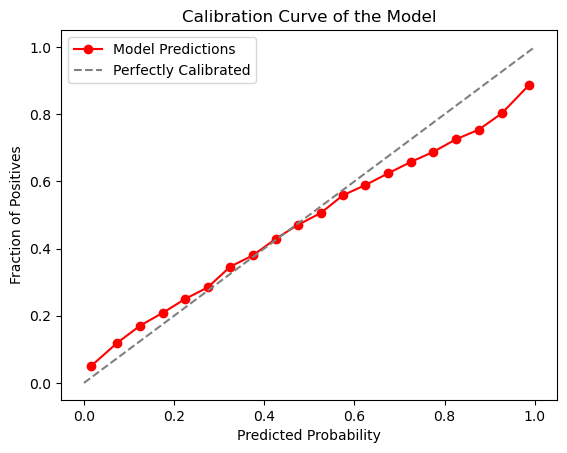

In [14]:
prob_true2, prob_pred2 = calibration_curve(Y_test, probs_with_race, n_bins=20)
plt.plot(prob_pred2, prob_true2, marker='o', linestyle='-', color='red', label='Model Predictions')    

plt.xlabel('Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve of the Model')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.legend()

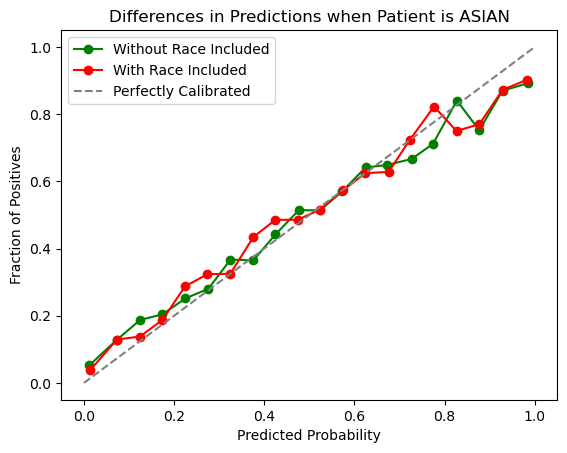

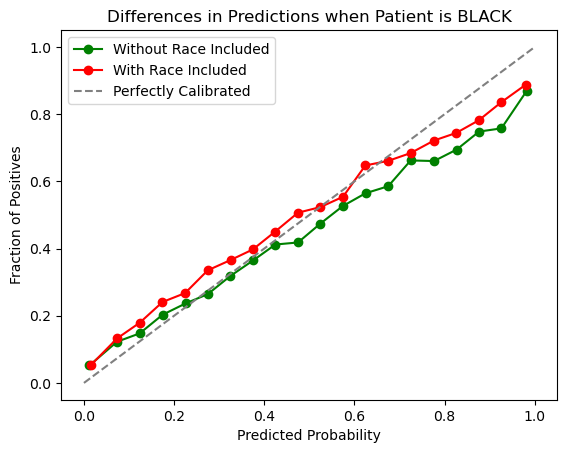

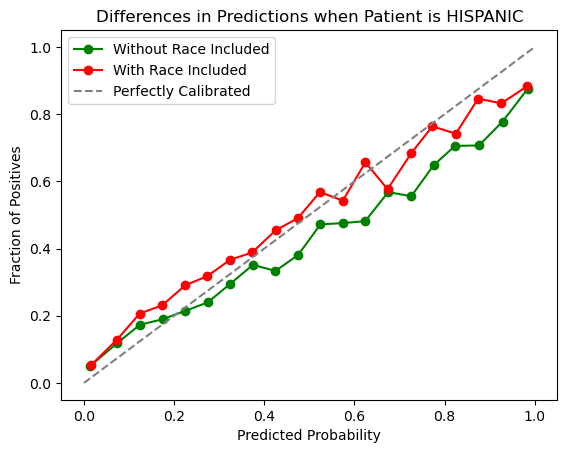

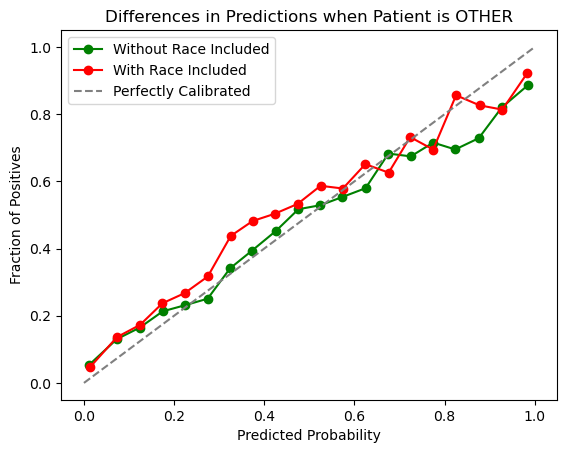

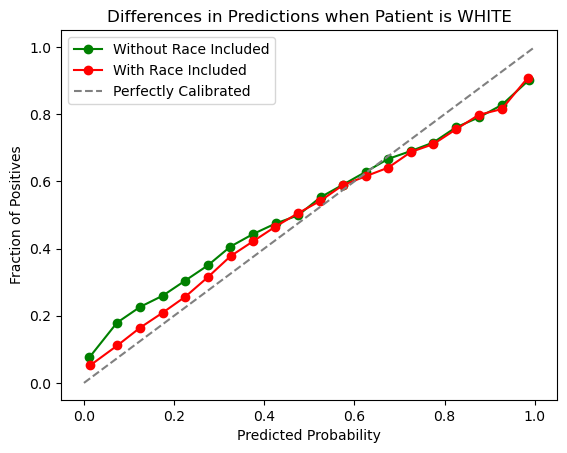

In [13]:
for race in races:
    plt.figure()
    # Calculate calibration curve
    prob_true1, prob_pred1 = calibration_curve(Y_test[masks[race]], probs_no_race[masks[race]], n_bins=20)
    plt.plot(prob_pred1, prob_true1, marker='o', linestyle='-', color='green', label='Without Race Included')

    prob_true2, prob_pred2 = calibration_curve(Y_test[masks[race]], probs_with_race[masks[race]], n_bins=20)
    plt.plot(prob_pred2, prob_true2, marker='o', linestyle='-', color='red', label='With Race Included')    

    plt.xlabel('Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Differences in Predictions when Patient is {race}')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.legend()
    

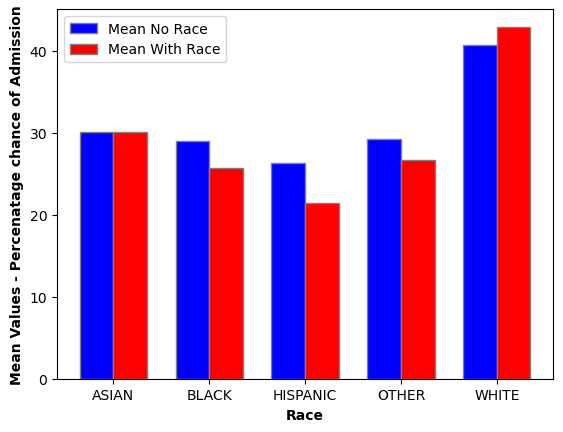

In [14]:
mean_no_race = []
mean_with_race = []

for race in races:
    mean_no_race.append(probs_no_race[masks[race]].mean()*100)
    mean_with_race.append(probs_with_race[masks[race]].mean()*100)
    
# Position of bars on X axis
bar_width = 0.35
r1 = np.arange(len(races))
r2 = [x + bar_width for x in r1]

# Create bars
plt.bar(r1, mean_no_race, color='b', width=bar_width, edgecolor='grey', label='Mean No Race')
plt.bar(r2, mean_with_race, color='r', width=bar_width, edgecolor='grey', label='Mean With Race')

# Add labels
plt.xlabel('Race', fontweight='bold')
plt.xticks([r + bar_width / 2 for r in range(len(races))], races)
plt.ylabel('Mean Values - Percenatage chance of Admission', fontweight='bold')

# Add legend
plt.legend()

# Show plot
plt.show()

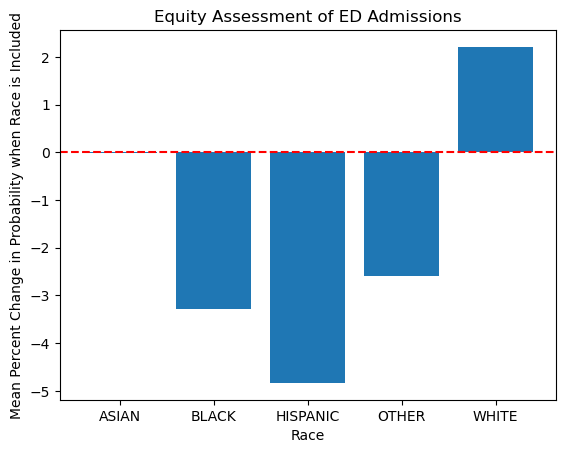

In [15]:
differences = []
for race in races:
    mean_dif = ((probs_with_race[masks[race]] - probs_no_race[masks[race]]).mean()) * 100
    differences.append(mean_dif)

plt.bar(races, differences)

plt.axhline(0, color='red', linestyle='--')

plt.xlabel('Race')
plt.ylabel('Mean Percent Change in Probability when Race is Included')
plt.title('Equity Assessment of ED Admissions')
plt.show()

### Let's explore the distributions further:

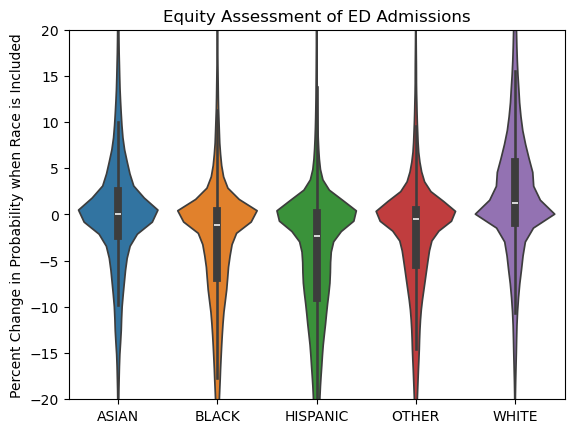

In [16]:
import seaborn as sns

dict_races = {race: None for race in races}

for race in races:
    dict_races[race] = ((probs_with_race[masks[race]]- probs_no_race[masks[race]])*100).flatten()

# Create the violin plot
sns.violinplot(data=list(dict_races.values()))

# Set the x-tick labels
plt.xticks(range(len(dict_races)), dict_races.keys())

plt.ylim(-20, 20) # Set y-axis limits to [-20,20]

plt.ylabel('Percent Change in Probability when Race is Included')
plt.title('Equity Assessment of ED Admissions')

# Show the plot
plt.show()


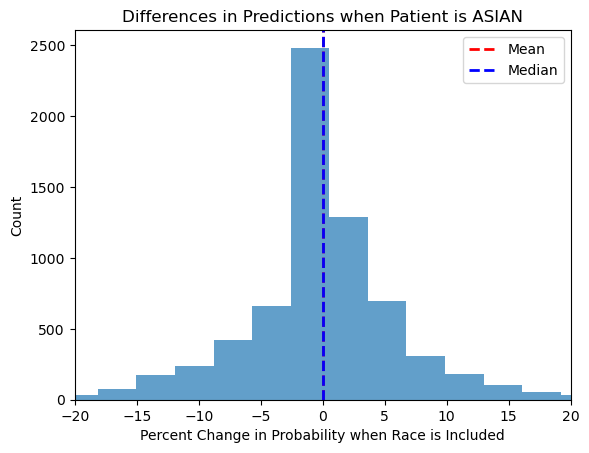

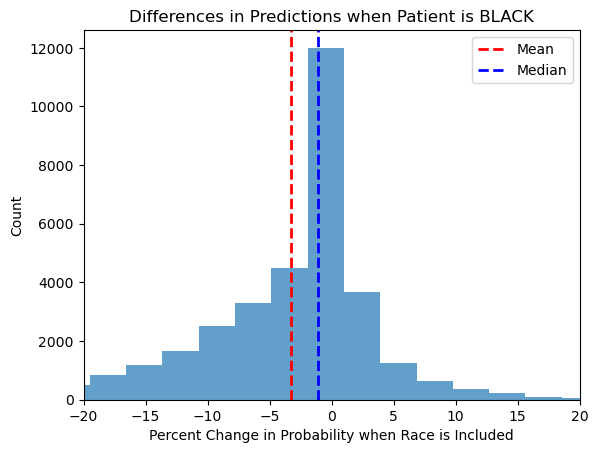

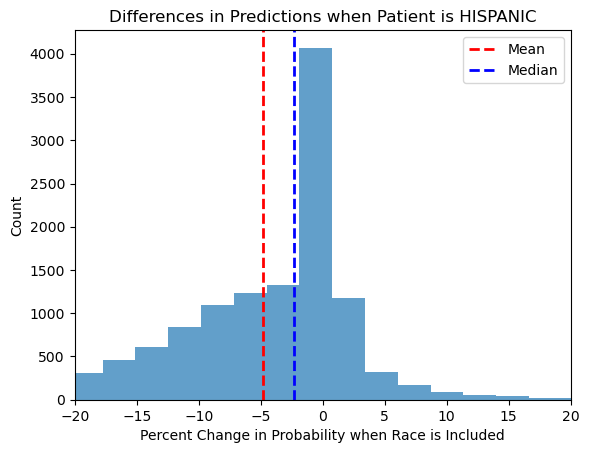

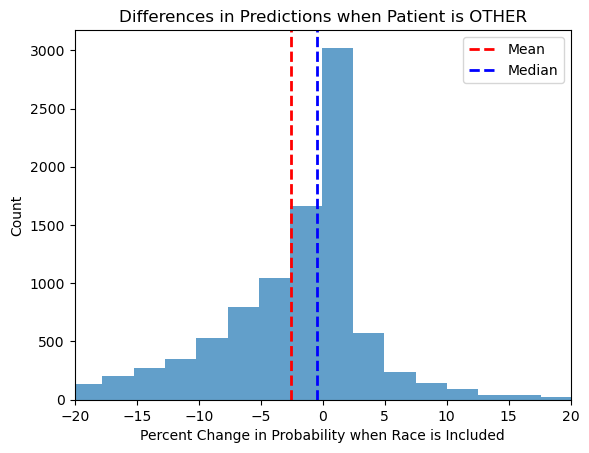

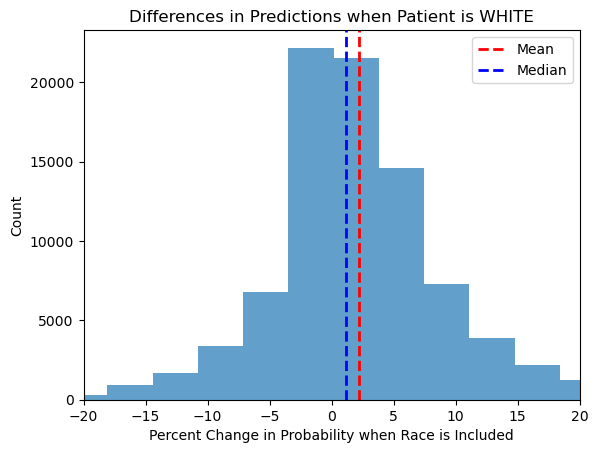

In [21]:
for race in races:
    plt.hist(dict_races[race], alpha=0.7, bins=40)
    
    # Add a vertical line at the mean
    plt.axvline(dict_races[race].mean(), color='r', linestyle='dashed', linewidth=2, label='Mean')

    sorted_values = sorted(dict_races[race])
    median = sorted_values[len(sorted_values) // 2]
    
    plt.axvline(median, color='b', linestyle='dashed', linewidth=2, label='Median')
    
    plt.xlabel('Percent Change in Probability when Race is Included')
    plt.ylabel('Count')
    # Set the bounds of x from -20 to 20
    plt.xlim(-20, 20)
    plt.title(f'Differences in Predictions when Patient is {race}')
    # Add legend
    plt.legend()
    plt.show()

Define two possible functions for calculating the p-value for the null hypothesis, the differences appear to be normally distributed so the t-test should be suitable:

In [ ]:
from scipy.stats import ttest_indfrom scipy.stats import mannwhitneyudef mann_whitney_u_test(arr1, arr2):    _, p_value = mannwhitneyu(arr1, arr2, alternative='greater')    return p_value

Now for comparing the predictions of a race with itself, to see if there is a statistically significant difference before and after race is included in the first place:

In [183]:
num_reruns = 30

p_values = [0.5, 0.2, 0.05, 0.01, 0.001]
# Comparison table for number of reruns where there is a statistically significant difference (columns greater than, rows smaller than)
p_value_tables = {p_value : np.zeros((len(races), len(races))) for p_value in p_values}
mean_differences = {race: np.zeros((num_reruns,)) for race in races}

for i in range(num_reruns):
    print(f'\nRun {i+1} of {num_reruns}\n')
    X_train, X_test, Y_train, Y_test = train_test_split(X_combined, Y, test_size=0.4)

    X_train1 = X_train[:, :-5]
    X_test1 = X_test[:, :-5]

    X_train2 = X_train
    X_test2 = X_test

    # Dictionary of array masks to correspond which races are at each index for easier computation
    masks = {race: None for race in races}
    
    for j in range(len(races)):
        masks[races[j]] = X_test2[:, -5+j] == 1

    probs_no_race = run_predictions(X_train1, X_test1, Y_train, Y_test, train_set=False, verbose=0)
    probs_with_race = run_predictions(X_train2, X_test2, Y_train, Y_test, train_set=False, verbose=0)
    
    dict_races = {race: None for race in races}

    for race in races:
        differences = (probs_no_race[masks[race]] - probs_with_race[masks[race]])*100
        dict_races[race] = (differences).flatten()
        mean_differences[race][i] = differences.mean()

    for k in range(len(p_values)):
        for j in range(len(races)):
            for l in range(len(races)):
                if j!=l:
                    p_value_tables[p_values[k]][j][l] += two_sample_t_test(dict_races[races[j]], dict_races[races[l]], value = 'greater') < p_values[k]
                else:
                    p_value_tables[p_values[k]][j][l] += paired_t_test(probs_no_race[masks[races[j]]], probs_with_race[masks[races[l]]]) < p_values[k]


Run 1 of 30

4703/4703 [==============================] - 2s 462us/step
Evaluation on Test Set:
 - Sensitivity: 0.5812 - Specificity: 0.8551 - AUC: 0.8143 - Accuracy: 0.7528
4703/4703 [==============================] - 2s 466us/step
Evaluation on Test Set:
 - Sensitivity: 0.6335 - Specificity: 0.8282 - AUC: 0.8214 - Accuracy: 0.7555
4703/4703 [==============================] - 2s 471us/step
Evaluation on Test Set:
 - Sensitivity: 0.6218 - Specificity: 0.8359 - AUC: 0.8223 - Accuracy: 0.7560
4703/4703 [==============================] - 2s 471us/step
Evaluation on Test Set:
 - Sensitivity: 0.5715 - Specificity: 0.8634 - AUC: 0.8170 - Accuracy: 0.7545
4703/4703 [==============================] - 2s 471us/step
Evaluation on Test Set:
 - Sensitivity: 0.5968 - Specificity: 0.8533 - AUC: 0.8233 - Accuracy: 0.7575
4703/4703 [==============================] - 2s 464us/step
Evaluation on Test Set:
 - Sensitivity: 0.5597 - Specificity: 0.8775 - AUC: 0.8276 - Accuracy: 0.7589
4703/4703 [=========

### Now we plot the p-value that the number of runs where the column is greater than the row for a given p-value (or that there is a difference between before and after race is included)

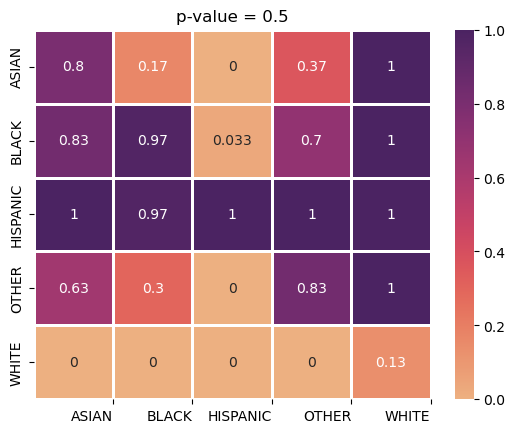

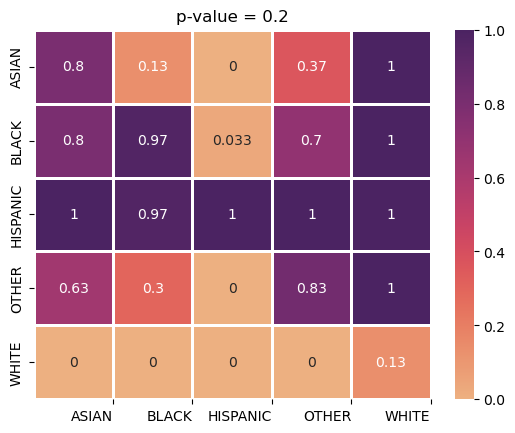

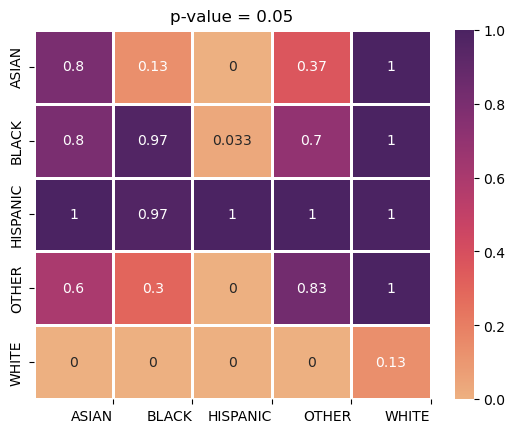

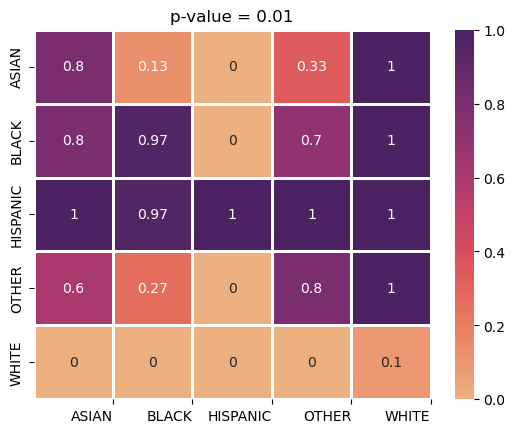

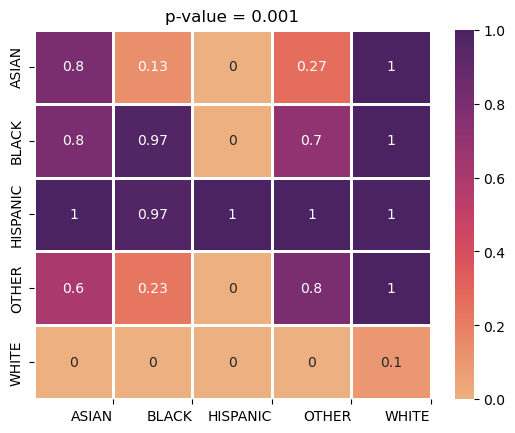

In [184]:
for p_value in p_values:
    table = p_value_tables[p_value]/num_reruns
    # Add black borders to the heatmap
    sns.heatmap(table, annot=True, cmap='flare', linewidths=2)
    
    # Set the x-tick labels to the race names
    # Shift the y-tick labels by 0.5 to center them
    plt.xticks(np.arange(len(races))+ 1, races, ha='right')
    plt.yticks(np.arange(len(races))+ 0.5, races, ha='right')
    
    plt.title(f'p-value = {p_value}')
    plt.show()

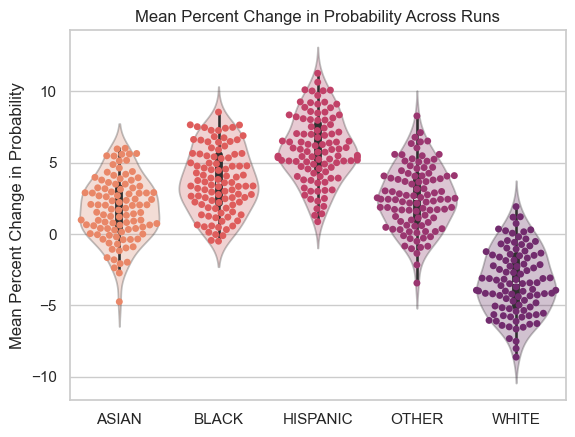

In [100]:
sns.swarmplot(data=mean_differences, palette='flare')

# Display a violin plot of the same data
sns.violinplot(data=mean_differences, palette='flare', alpha=0.3)
plt.ylabel('Mean Percent Change in Probability')
plt.title('Mean Percent Change in Probability Across Runs')
plt.show()

## Code Improvement: Simultaneous Training and Ensuring Equivalent Weight Initialization for Standardization

Try out the new approach with a single run

In [65]:
seed = 33

X_train, X_test, Y_train, Y_test = train_test_split(X_combined, Y, test_size=0.3)

Y_train = Y_train.astype('float32')
Y_test = Y_test.astype('float32')

X_train_num, X_test_num, X_train_encoded, X_test_encoded = encode_and_split_new(X_train, X_test)

# Dictionary of array masks to correspond which races are at each index for easier computation
masks = {race: None for race in races}

for j in range(len(races)):
    masks[races[j]] = X_test[:, -5+j] == 1

model1 = create_nn([64, 32], [32], X_train_encoded.shape[1], X_train_num.shape[1] - 5, seed=seed)

model2 = create_nn([64, 32], [32], X_train_encoded.shape[1], X_train_num.shape[1], seed=seed)

# Make sure the models have the same initialized weights
model1, model2 = equate_weights(model1, model2)

Layer 0:

Layer 1:
Shapes 0: (1006, 64) , (1006, 64)
Weights are equal, no changes needed
Shapes 1: (64,) , (64,)
Weights are equal, no changes needed

Layer 2:

Layer 3:
Shapes 0: (64, 32) , (64, 32)
Weights are equal, no changes needed
Shapes 1: (32,) , (32,)
Weights are equal, no changes needed

Layer 4:

Layer 5:
Shapes 0: (45, 32) , (50, 32)
-----WEIGHTS UPDATED-----
Shapes 1: (32,) , (32,)
Weights are equal, no changes needed

Layer 6:
Shapes 0: (32, 1) , (32, 1)
Weights are equal, no changes needed
Shapes 1: (1,) , (1,)
Weights are equal, no changes needed



In [66]:
optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.001)

optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.001)

loss_fn = BinaryExpectedCalibrationError(num_bins=10)

train_simultaneously(X_train_num, X_train_encoded, Y_train, X_test_num, X_test_encoded, Y_test,
                         model1, model2, optimizer1, optimizer2, loss_fn, epochs=4, batch_size=32)

Epoch 1/4


100%|██████████| 8230/8230 [03:18<00:00, 41.44it/s]


Epoch 1:
- Training Loss model 1 (no race): 0.17000000178813934
- Training Loss model 2 (race included): 0.17100000381469727
- Training Accuracy model 1: 74.99%
- Training Accuracy model 2: 75.00%
- Test Loss model 1 (no race): 0.16899999976158142
- Test Loss model 2 (race included): 0.17100000381469727
- Test Accuracy model 1: 76.73%
- Test Accuracy model 2: 76.73%
Epoch 2/4


 10%|█         | 864/8230 [00:20<02:58, 41.18it/s]


KeyboardInterrupt: 

In [20]:
bins = 20

probs_no_race = model1.predict([X_test_num[:, :-5], X_test_encoded])
probs_with_race = model2.predict([X_test_num, X_test_encoded])

baseline_acc_metric = tf.keras.metrics.BinaryAccuracy()
baseline_ece_metric = BinaryExpectedCalibrationError(num_bins=bins)
print('Baseline Metrics on all Test Data')
baseline_acc_no_race = baseline_acc_metric(Y_test, probs_no_race)
baseline_acc_with_race = baseline_acc_metric(Y_test, probs_with_race)

baseline_ece_no_race = baseline_ece_metric(Y_test, probs_no_race)
baseline_ece_with_race = baseline_ece_metric(Y_test, probs_no_race)

print(f'- Accuracy no race: {baseline_acc_no_race*100}%')
print(f'- Accuracy with race: {baseline_acc_with_race*100}%')
print(f'- ECE no race: {baseline_ece_no_race}')
print(f'- ECE with race: {baseline_ece_with_race}\n')


for race in races:
    acc_metric = tf.keras.metrics.BinaryAccuracy()
    ece_metric = BinaryExpectedCalibrationError(num_bins=bins)
    print(f'Race: {race}')
    acc_no_race = acc_metric(Y_test[masks[race]], probs_no_race[masks[race]])
    acc_with_race = acc_metric(Y_test[masks[race]], probs_with_race[masks[race]])
    print(f'- Accuracy no race: {acc_no_race*100}%')
    print(f'- Accuracy with race: {acc_with_race*100}%')
    ece_no_race = ece_metric(Y_test[masks[race]], probs_no_race[masks[race]])
    ece_with_race = ece_metric(Y_test[masks[race]], probs_with_race[masks[race]])
    print(f'- ECE no race: {ece_no_race}')
    print(f'- ECE with race: {ece_with_race}\n')
    

 235/3527 [>.............................] - ETA: 1s

2024-12-05 11:45:31.290034: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3527/3527 [==============================] - 2s 437us/step
Baseline Metrics on all Test Data
- Accuracy no race: 77.08570098876953%
- Accuracy with race: 77.12467956542969%
- ECE no race: 0.0362841859459877
- ECE with race: 0.0362841859459877

Race: ASIAN
- Accuracy no race: 80.16413116455078%
- Accuracy with race: 80.28422546386719%
- ECE no race: 0.03184232488274574
- ECE with race: 0.04449398070573807

Race: BLACK
- Accuracy no race: 78.66671752929688%
- Accuracy with race: 78.82752227783203%
- ECE no race: 0.04583307355642319
- ECE with race: 0.045997243374586105

Race: HISPANIC
- Accuracy no race: 80.42127227783203%
- Accuracy with race: 80.5318603515625%
- ECE no race: 0.05246139317750931
- ECE with race: 0.04420845955610275

Race: OTHER
- Accuracy no race: 80.16787719726562%
- Accuracy with race: 80.32437133789062%
- ECE no race: 0.03653419390320778
- ECE with race: 0.040857285261154175

Race: WHITE
- Accuracy no race: 75.44514465332031%
- Accuracy with race: 75.40886688232422%


3527/3527 [==============================] - 1s 408us/step


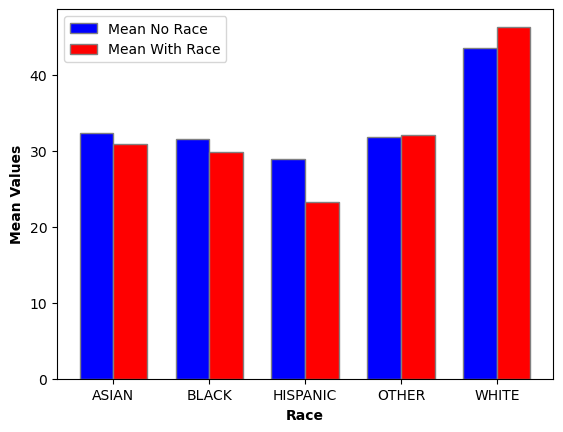

In [21]:
probs_no_race = model1.predict([X_test_num[:, :-5], X_test_encoded])
probs_with_race = model2.predict([X_test_num, X_test_encoded])

mean_no_race = []
mean_with_race = []

for race in races:
    mean_no_race.append(probs_no_race[masks[race]].mean()*100)
    mean_with_race.append(probs_with_race[masks[race]].mean()*100)
    
# Position of bars on X axis
bar_width = 0.35
r1 = np.arange(len(races))
r2 = [x + bar_width for x in r1]

# Create bars
plt.bar(r1, mean_no_race, color='b', width=bar_width, edgecolor='grey', label='Mean No Race')
plt.bar(r2, mean_with_race, color='r', width=bar_width, edgecolor='grey', label='Mean With Race')

# Add labels
plt.xlabel('Race', fontweight='bold')
plt.xticks([r + bar_width / 2 for r in range(len(races))], races)
plt.ylabel('Mean Values', fontweight='bold')

# Add legend
plt.legend()

# Show plot
plt.show()

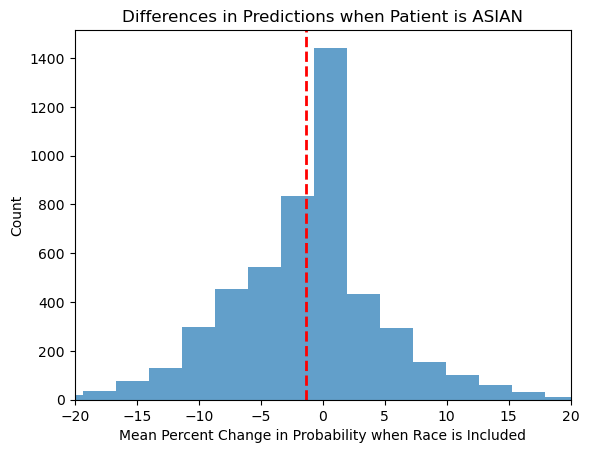

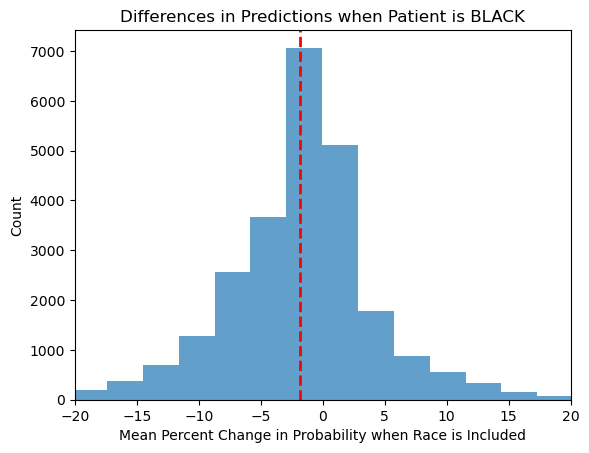

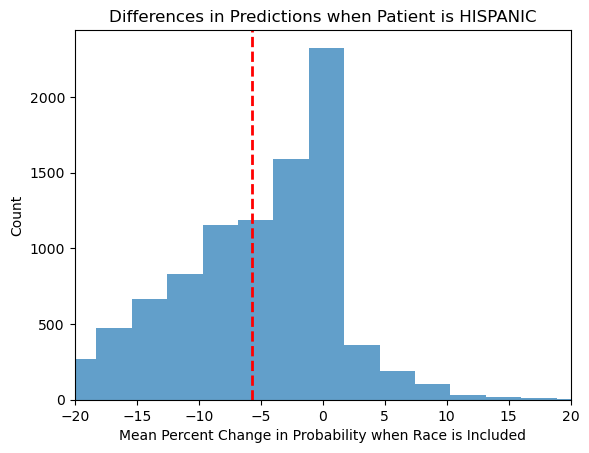

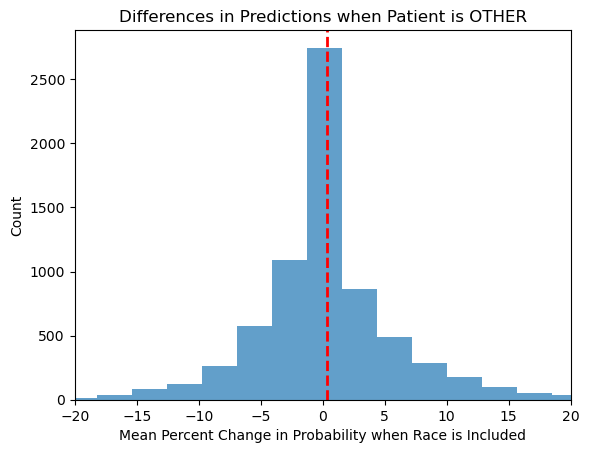

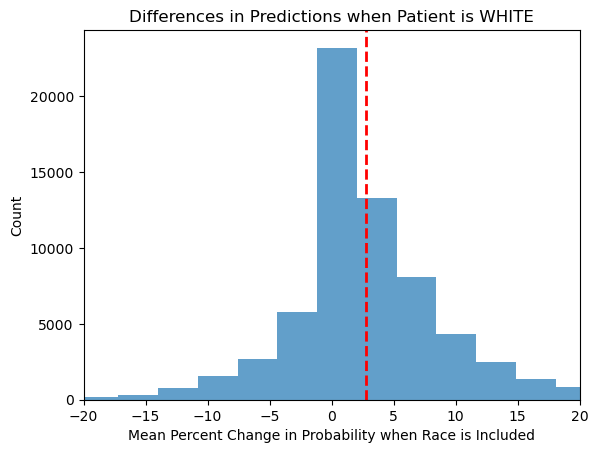

In [22]:
for race in races:
    probs_no_race[masks[race]]
    diffs = (probs_with_race[masks[race]] - probs_no_race[masks[race]])*100
    
    plt.hist(diffs, alpha=0.7, bins=40)
    
    # Add a vertical line at the mean
    plt.axvline(diffs.mean(), color='r', linestyle='dashed', linewidth=2)
    
    plt.xlim(-20, 20)
    
    plt.xlabel('Mean Percent Change in Probability when Race is Included')
    plt.ylabel('Count')
    plt.title(f'Differences in Predictions when Patient is {race}')
    plt.show()

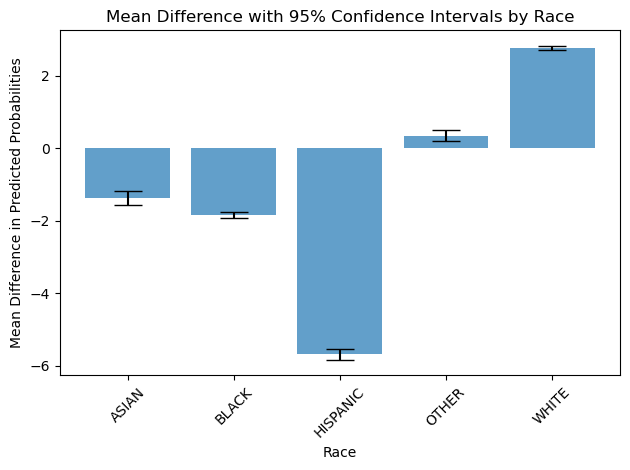

In [23]:
z_value = stats.norm.ppf(0.975)

means = []
lower_bounds = []
upper_bounds = []

# Compute means and confidence intervals for each race
for race in races:
    diff_race = probs_with_race[masks[race]] - probs_no_race[masks[race]]
    mean_diff = diff_race.mean()
    means.append(mean_diff*100)
    
    # Compute standard error
    se = diff_race.std(ddof=1) / np.sqrt(len(diff_race))
    # Compute 95% confidence interval
    lower_bound = mean_diff - z_value * se
    upper_bound = mean_diff + z_value * se
    lower_bounds.append(lower_bound*100)
    upper_bounds.append(upper_bound*100)

# Calculate error bars (half the width of the confidence intervals)
errors = [upper - mean for mean, upper in zip(means, upper_bounds)]

# Plotting
x_pos = np.arange(len(races))

plt.bar(x_pos, means, yerr=errors, alpha=0.7, capsize=10)
plt.xticks(x_pos, races, rotation=45)
plt.xlabel('Race')
plt.ylabel('Mean Difference in Predicted Probabilities')
plt.title('Mean Difference with 95% Confidence Intervals by Race')
plt.tight_layout()
plt.show()


In [31]:
diff_races = [probs_with_race[masks[race]] - probs_no_race[masks[race]] for race in races]

f_statistic, p_value = stats.f_oneway(*diff_races)


print("ANOVA Test to Analyze Differences in Predictions by Race:")
print("  - F-statistic:", f_statistic)
print("  - p-value:", p_value)

ANOVA Test to Analyze Differences in Predictions by Race:
  - F-statistic: [4457.76951017]
  - p-value: [0.]


In [35]:
for race in races:
    print(f'------------------- {race} Patients -------------------')
    p_value_paired = paired_t_test(probs_with_race[masks[race]], probs_no_race[masks[race]])
    
    print(f'Paired t-test p-value: {p_value_paired}')
    print(f'Difference Comparisons')
    
    diff_race = (probs_with_race[masks[race]] - probs_no_race[masks[race]])
    
    for race2 in races:
        if race != race2:
            diff_race2 = (probs_with_race[masks[race2]] - probs_no_race[masks[race2]])
            p_value = two_sample_t_test(diff_race, diff_race2, value ='greater')
            print(f'     - Prediction difference for {race} > {race2}: {p_value}')
            
    print()

------------------- ASIAN Patients -------------------
Paired t-test p-value: [6.2809614e-42]
Difference Comparisons
     - Prediction difference for ASIAN > BLACK: [1.6794982e-05]
     - Prediction difference for ASIAN > HISPANIC: [0.]
     - Prediction difference for ASIAN > OTHER: [1.]
     - Prediction difference for ASIAN > WHITE: [1.]

------------------- BLACK Patients -------------------
Paired t-test p-value: [0.]
Difference Comparisons
     - Prediction difference for BLACK > ASIAN: [0.9999832]
     - Prediction difference for BLACK > HISPANIC: [0.]
     - Prediction difference for BLACK > OTHER: [1.]
     - Prediction difference for BLACK > WHITE: [1.]

------------------- HISPANIC Patients -------------------
Paired t-test p-value: [0.]
Difference Comparisons
     - Prediction difference for HISPANIC > ASIAN: [1.]
     - Prediction difference for HISPANIC > BLACK: [1.]
     - Prediction difference for HISPANIC > OTHER: [1.]
     - Prediction difference for HISPANIC > WHITE:

## Trying class balancing (First Attempt)

Here we will just try and balance all classes, which may skew the data as we are repeating a lot of samples from the larger minority classes such as Hispanic, Asian and Other.

In [ ]:
from imblearn.under_sampling import RandomUnderSamplerfrom imblearn.over_sampling import RandomOverSamplerseed = 33X_train, X_test, Y_train, Y_test = train_test_split(X_combined, Y, test_size=0.3)Y_train = Y_train.astype('float32')Y_test = Y_test.astype('float32')X_train_num, X_test_num, X_train_encoded, X_test_encoded = encode_and_split_new(X_train, X_test)X_train_num, X_train_encoded, Y_train = balance_classes(X_train_num, X_train_encoded, Y_train)X_test_num, X_test_encoded, Y_test = balance_classes(X_test_num, X_test_encoded, Y_test)masks = {race: None for race in races}for j in range(len(races)):    masks[races[j]] = X_train_num[:, -5+j] == 1print('On training data:')for race in races:    print(f'Race: {race}')    length = (len(merged_df[merged_df['race']==race]))    print(f'- Length of {length} before balancing')    print(f'- After balancing: {len(X_train_num[masks[race]])}')

On training data:
Race: ASIAN
- Length of 16868 before balancing
- After balancing: 154100
Race: BLACK
- Length of 84087 before balancing
- After balancing: 154100
Race: HISPANIC
- Length of 31392 before balancing
- After balancing: 154100
Race: OTHER
- Length of 23700 before balancing
- After balancing: 154100
Race: WHITE
- Length of 220164 before balancing
- After balancing: 154100


In [64]:
model1 = create_nn([64, 32], [32], X_train_encoded.shape[1], X_train_num.shape[1] - 5, seed=seed)

model2 = create_nn([64, 32], [32], X_train_encoded.shape[1], X_train_num.shape[1], seed=seed)

# Make sure the models have the same initialized weights
model1, model2 = equate_weights(model1, model2, verbose=False)

optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.001)

optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.001)

loss_fn = BinaryExpectedCalibrationError(num_bins=10)

train_simultaneously(X_train_num, X_train_encoded, Y_train, X_test_num, X_test_encoded, Y_test,
                         model1, model2, optimizer1, optimizer2, loss_fn, epochs=2, batch_size=32)

Epoch 1/2


100%|██████████| 24079/24079 [09:40<00:00, 41.49it/s]


Epoch 1:
- Training Loss model 1 (no race): 0.15800000727176666
- Training Loss model 2 (race included): 0.15700000524520874
- Training Accuracy model 1: 79.14%
- Training Accuracy model 2: 79.16%
- Test Loss model 1 (no race): 0.1599999964237213
- Test Loss model 2 (race included): 0.16200000047683716
- Test Accuracy model 1: 79.08%
- Test Accuracy model 2: 78.98%
Epoch 2/2


100%|██████████| 24079/24079 [08:44<00:00, 45.93it/s]


Epoch 2:
- Training Loss model 1 (no race): 0.15399999916553497
- Training Loss model 2 (race included): 0.15299999713897705
- Training Accuracy model 1: 80.13%
- Training Accuracy model 2: 80.23%
- Test Loss model 1 (no race): 0.16300000250339508
- Test Loss model 2 (race included): 0.1599999964237213
- Test Accuracy model 1: 78.74%
- Test Accuracy model 2: 79.29%


In [65]:
masks2 = {race: None for race in races}

for j in range(len(races)):
    masks2[races[j]] = X_test_num[:, -5+j] == 1

10323/10323 [==============================] - 6s 574us/step


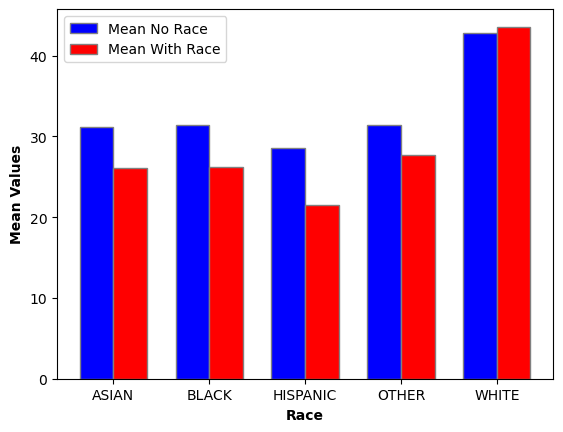

In [66]:
probs_no_race = model1.predict([X_test_num[:, :-5], X_test_encoded])
probs_with_race = model2.predict([X_test_num, X_test_encoded])

mean_no_race = []
mean_with_race = []

for race in races:
    mean_no_race.append(probs_no_race[masks2[race]].mean()*100)
    mean_with_race.append(probs_with_race[masks2[race]].mean()*100)
    
# Position of bars on X axis
bar_width = 0.35
r1 = np.arange(len(races))
r2 = [x + bar_width for x in r1]

# Create bars
plt.bar(r1, mean_no_race, color='b', width=bar_width, edgecolor='grey', label='Mean No Race')
plt.bar(r2, mean_with_race, color='r', width=bar_width, edgecolor='grey', label='Mean With Race')

# Add labels
plt.xlabel('Race', fontweight='bold')
plt.xticks([r + bar_width / 2 for r in range(len(races))], races)
plt.ylabel('Mean Values', fontweight='bold')

# Add legend
plt.legend()

# Show plot
plt.show()

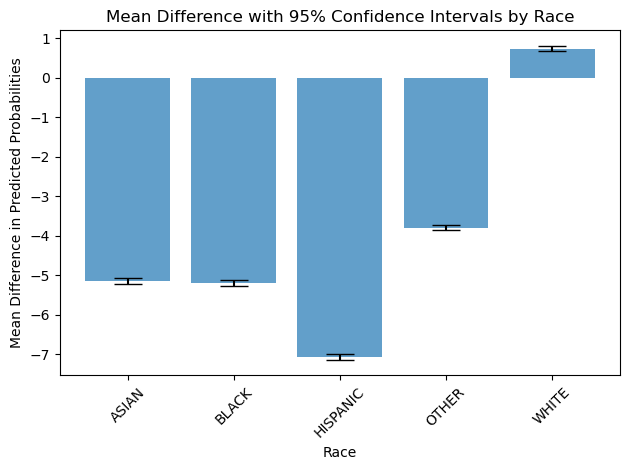

In [67]:
z_value = stats.norm.ppf(0.975)

means = []
lower_bounds = []
upper_bounds = []

# Compute means and confidence intervals for each race
for race in races:
    diff_race = probs_with_race[masks2[race]] - probs_no_race[masks2[race]]
    mean_diff = diff_race.mean()
    means.append(mean_diff*100)
    
    # Compute standard error
    se = diff_race.std(ddof=1) / np.sqrt(len(diff_race))
    # Compute 95% confidence interval
    lower_bound = mean_diff - z_value * se
    upper_bound = mean_diff + z_value * se
    lower_bounds.append(lower_bound*100)
    upper_bounds.append(upper_bound*100)

# Calculate error bars (half the width of the confidence intervals)
errors = [upper - mean for mean, upper in zip(means, upper_bounds)]

# Plotting
x_pos = np.arange(len(races))

plt.bar(x_pos, means, yerr=errors, alpha=0.7, capsize=10)
plt.xticks(x_pos, races, rotation=45)
plt.xlabel('Race')
plt.ylabel('Mean Difference in Predicted Probabilities')
plt.title('Mean Difference with 95% Confidence Intervals by Race')
plt.tight_layout()
plt.show()

In [68]:
for race in races:
    print(f'------------------- {race} Patients -------------------')
    p_value_paired = paired_t_test(probs_with_race[masks2[race]], probs_no_race[masks2[race]])
    
    print(f'Paired t-test p-value: {p_value_paired}')
    print(f'Difference Comparisons')
    
    diff_race = (probs_with_race[masks2[race]] - probs_no_race[masks2[race]])
    
    for race2 in races:
        if race != race2:
            diff_race2 = (probs_with_race[masks2[race2]] - probs_no_race[masks2[race2]])
            p_value = two_sample_t_test(diff_race, diff_race2, value ='greater')
            print(f'     - Prediction difference for {race} > {race2}: {p_value}')
            
    print()

------------------- ASIAN Patients -------------------
Paired t-test p-value: [0.]
Difference Comparisons
     - Prediction difference for ASIAN > BLACK: [0.15685923]
     - Prediction difference for ASIAN > HISPANIC: [4.2296209e-252]
     - Prediction difference for ASIAN > OTHER: [1.]
     - Prediction difference for ASIAN > WHITE: [1.]

------------------- BLACK Patients -------------------
Paired t-test p-value: [0.]
Difference Comparisons
     - Prediction difference for BLACK > ASIAN: [0.84314077]
     - Prediction difference for BLACK > HISPANIC: [1.90534426e-268]
     - Prediction difference for BLACK > OTHER: [1.]
     - Prediction difference for BLACK > WHITE: [1.]

------------------- HISPANIC Patients -------------------
Paired t-test p-value: [0.]
Difference Comparisons
     - Prediction difference for HISPANIC > ASIAN: [1.]
     - Prediction difference for HISPANIC > BLACK: [1.]
     - Prediction difference for HISPANIC > OTHER: [1.]
     - Prediction difference for HISPA

In [23]:
num_reruns = 50

p_values = [0.2, 0.05, 0.01, 0.001]
# Comparison table for number of reruns where there is a statistically significant difference (columns greater than, rows smaller than)
p_value_tables = {p_value : np.zeros((len(races), len(races))) for p_value in p_values}
mean_differences = {race: np.zeros((num_reruns,)) for race in races}

for i in range(num_reruns):
    print(f'\nRun {i+1} of {num_reruns}\n')
    
    seed = np.random.randint(1, 100)
    
    seed = 33

    X_train, X_test, Y_train, Y_test = train_test_split(X_combined, Y, test_size=0.3)

    Y_train = Y_train.astype('float32')
    Y_test = Y_test.astype('float32')

    X_train_num, X_test_num, X_train_encoded, X_test_encoded = encode_and_split_new(X_train, X_test)

    # Dictionary of array masks to correspond which races are at each index for easier computation
    masks = {race: None for race in races}

    for j in range(len(races)):
        masks[races[j]] = X_test_num[:, -5+j] == 1

    model1 = create_nn([64, 32], [32], X_train_encoded.shape[1], X_train_num.shape[1] - 5, seed=seed)

    model2 = create_nn([64, 32], [32], X_train_encoded.shape[1], X_train_num.shape[1], seed=seed)

    # Make sure the models have the same initialized weights
    model1, model2 = equate_weights(model1, model2, verbose=False)

    optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.001)

    optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.001)

    loss_fn = BinaryExpectedCalibrationError(num_bins=10)

    train_simultaneously(X_train_num, X_train_encoded, Y_train, X_test_num, X_test_encoded, Y_test,
                            model1, model2, optimizer1, optimizer2, loss_fn, epochs=3, batch_size=32)

    probs_no_race = model1.predict([X_test_num[:, :-5], X_test_encoded])
    probs_with_race = model2.predict([X_test_num, X_test_encoded])
    
    dict_races = {race: None for race in races}

    for race in races:
        differences = (probs_with_race[masks[race]] - probs_no_race[masks[race]])*100
        dict_races[race] = (differences).flatten()
        mean_differences[race][i] = differences.mean()

    for k in range(len(p_values)):
        # Checking for every specified p-value
        for j in range(len(races)):
            # Rows
            for l in range(len(races)):
                # Columns
                if j!=l:
                    # Does the two value t-test for two sample sets, checking if diff_row is greater than diff_column
                    p_value_tables[p_values[k]][j][l] += two_sample_t_test(dict_races[races[j]], dict_races[races[l]], value = 'greater') < p_values[k]
                else:
                    # Does the paired t-test to check a race against itself, checking if the probs_no_race is different from probs_with_race
                    p_value_tables[p_values[k]][j][l] += paired_t_test(probs_no_race[masks[races[j]]], probs_with_race[masks[races[l]]]) < p_values[k]


Run 1 of 30



IndexError: tuple index out of range

In [36]:
seed = 33

X_train, X_test, Y_train, Y_test = train_test_split(X_combined, Y, test_size=0.3)

Y_train = Y_train.astype('float32')
Y_test = Y_test.astype('float32')

X_train_num, X_test_num, X_train_encoded, X_test_encoded = encode_and_split_new(X_train, X_test)

# Dictionary of array masks to correspond which races are at each index for easier computation
masks = {race: None for race in races}

for j in range(len(races)):
    masks[races[j]] = X_test[:, -5+j] == 1

model1 = create_nn([64, 32], [32], X_train_encoded.shape[1], X_train_num.shape[1] - 5, seed=seed)

model2 = create_nn([64, 32], [32], X_train_encoded.shape[1], X_train_num.shape[1], seed=seed)

# Make sure the models have the same initialized weights
model1, model2 = equate_weights(model1, model2, verbose=False)

In [38]:
proportions

[0.04483654119629676,
 0.22351021102519597,
 0.0834425362363142,
 0.06299656309889928,
 0.5852141484432938]

In [39]:
randomn_data = generate_one_hot(proportions, len(X_combined))
verify_proportions(randomn_data, proportions, categories=races)

ASIAN: Expected Proportion = 0.04, Actual Proportion = 0.04
BLACK: Expected Proportion = 0.22, Actual Proportion = 0.22
HISPANIC: Expected Proportion = 0.08, Actual Proportion = 0.08
OTHER: Expected Proportion = 0.06, Actual Proportion = 0.06
WHITE: Expected Proportion = 0.59, Actual Proportion = 0.59


# Keep

In [40]:
X_train_num_rand = X_train_num.copy()
X_train_num_rand[:, -5:] = randomn_data[:X_train_num.shape[0]]
X_test_num_rand = X_test_num.copy()
X_test_num_rand[:, -5:] = randomn_data[X_train_num.shape[0]:]

optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.001)

optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.001)

loss_fn = BinaryExpectedCalibrationError(num_bins=10)

train_simultaneously(X_train_num_rand, X_train_encoded, Y_train, X_test_num_rand, X_test_encoded, Y_test,
                         model1, model2, optimizer1, optimizer2, loss_fn, epochs=4, batch_size=32)

Epoch 1/4


100%|██████████| 8230/8230 [02:33<00:00, 53.53it/s]


Epoch 1:
- Training Loss model 1 (no race): 0.17100000381469727
- Training Loss model 2 (race included): 0.17100000381469727
- Training Accuracy model 1: 75.17%
- Training Accuracy model 2: 74.96%
- Test Loss model 1 (no race): 0.17000000178813934
- Test Loss model 2 (race included): 0.1679999977350235
- Test Accuracy model 1: 76.81%
- Test Accuracy model 2: 76.71%
Epoch 2/4


100%|██████████| 8230/8230 [02:33<00:00, 53.71it/s]


Epoch 2:
- Training Loss model 1 (no race): 0.16899999976158142
- Training Loss model 2 (race included): 0.17000000178813934
- Training Accuracy model 1: 76.76%
- Training Accuracy model 2: 76.72%
- Test Loss model 1 (no race): 0.16899999976158142
- Test Loss model 2 (race included): 0.17000000178813934
- Test Accuracy model 1: 76.77%
- Test Accuracy model 2: 76.91%
Epoch 3/4


100%|██████████| 8230/8230 [02:33<00:00, 53.62it/s]


Epoch 3:
- Training Loss model 1 (no race): 0.16899999976158142
- Training Loss model 2 (race included): 0.16899999976158142
- Training Accuracy model 1: 76.98%
- Training Accuracy model 2: 76.94%
- Test Loss model 1 (no race): 0.1679999977350235
- Test Loss model 2 (race included): 0.16899999976158142
- Test Accuracy model 1: 77.03%
- Test Accuracy model 2: 77.04%
Epoch 4/4


100%|██████████| 8230/8230 [02:36<00:00, 52.67it/s]


Epoch 4:
- Training Loss model 1 (no race): 0.1679999977350235
- Training Loss model 2 (race included): 0.1679999977350235
- Training Accuracy model 1: 77.13%
- Training Accuracy model 2: 77.02%
- Test Loss model 1 (no race): 0.16599999368190765
- Test Loss model 2 (race included): 0.16899999976158142
- Test Accuracy model 1: 77.05%
- Test Accuracy model 2: 77.11%


3527/3527 [==============================] - 2s 528us/step


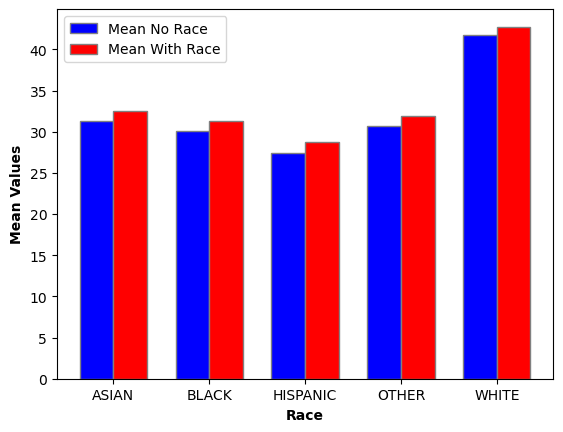

In [41]:
probs_no_race = model1.predict([X_test_num_rand[:, :-5], X_test_encoded])
probs_with_race = model2.predict([X_test_num_rand, X_test_encoded])

mean_no_race = []
mean_with_race = []

for race in races:
    mean_no_race.append(probs_no_race[masks[race]].mean()*100)
    mean_with_race.append(probs_with_race[masks[race]].mean()*100)
    
# Position of bars on X axis
bar_width = 0.35
r1 = np.arange(len(races))
r2 = [x + bar_width for x in r1]

# Create bars
plt.bar(r1, mean_no_race, color='b', width=bar_width, edgecolor='grey', label='Mean No Race')
plt.bar(r2, mean_with_race, color='r', width=bar_width, edgecolor='grey', label='Mean With Race')

# plt.errorbar(r1, mean_no_race, yerr=probs_no_race[masks[race]].std()*100, fmt='o', color='b')

# Add labels
plt.xlabel('Race', fontweight='bold')
plt.xticks([r + bar_width / 2 for r in range(len(races))], races)
plt.ylabel('Mean Values', fontweight='bold')

# Add legend
plt.legend()

# Show plot
plt.show()

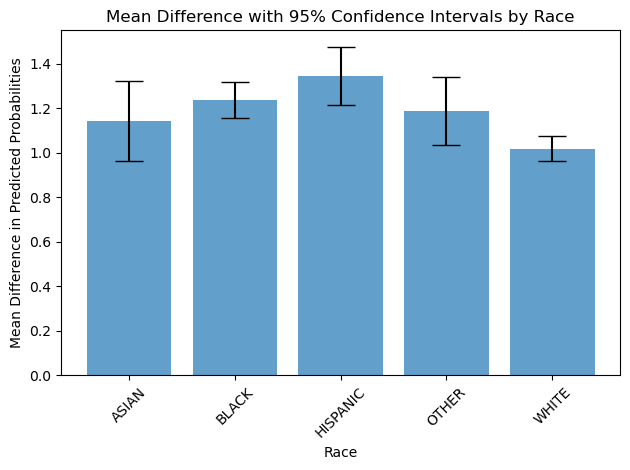

In [42]:
z_value = stats.norm.ppf(0.975)

means = []
lower_bounds = []
upper_bounds = []

# Compute means and confidence intervals for each race
for race in races:
    diff_race = probs_with_race[masks[race]] - probs_no_race[masks[race]]
    mean_diff = diff_race.mean()
    means.append(mean_diff*100)
    
    # Compute standard error
    se = diff_race.std(ddof=1) / np.sqrt(len(diff_race))
    # Compute 95% confidence interval
    lower_bound = mean_diff - z_value * se
    upper_bound = mean_diff + z_value * se
    lower_bounds.append(lower_bound*100)
    upper_bounds.append(upper_bound*100)

# Calculate error bars (half the width of the confidence intervals)
errors = [upper - mean for mean, upper in zip(means, upper_bounds)]

# Plotting
x_pos = np.arange(len(races))

plt.bar(x_pos, means, yerr=errors, alpha=0.7, capsize=10)
plt.xticks(x_pos, races, rotation=45)
plt.xlabel('Race')
plt.ylabel('Mean Difference in Predicted Probabilities')
plt.title('Mean Difference with 95% Confidence Intervals by Race')
plt.tight_layout()
plt.show()

In [43]:
diff_races = [probs_with_race[masks[race]] - probs_no_race[masks[race]] for race in races]

f_statistic, p_value = stats.f_oneway(*diff_races)


print("ANOVA Test to Analyze Differences in Predictions by Race:")
print("  - F-statistic:", f_statistic)
print("  - p-value:", p_value)

ANOVA Test to Analyze Differences in Predictions by Race:
  - F-statistic: [7.80806782]
  - p-value: [2.75013362e-06]


In [77]:
for race in races:
    print(f'------------------- {race} Patients -------------------')
    p_value_paired = paired_t_test(probs_with_race[masks[race]], probs_no_race[masks[race]])
    
    print(f'Paired t-test p-value: {p_value_paired}')
    print(f'Difference Comparisons')
    
    diff_race = (probs_with_race[masks[race]] - probs_no_race[masks[race]])
    
    for race2 in races:
        if race != race2:
            diff_race2 = (probs_with_race[masks[race2]] - probs_no_race[masks[race2]])
            p_value = two_sample_t_test(diff_race, diff_race2, value ='greater')
            print(f'     - Prediction difference for {race} > {race2}: {p_value}')
            
    print()

------------------- ASIAN Patients -------------------
Paired t-test p-value: [1.93919224e-05]
Difference Comparisons
     - Prediction difference for ASIAN > BLACK: [0.80513173]
     - Prediction difference for ASIAN > HISPANIC: [0.9206785]
     - Prediction difference for ASIAN > OTHER: [0.8811697]
     - Prediction difference for ASIAN > WHITE: [0.11325155]

------------------- BLACK Patients -------------------
Paired t-test p-value: [1.01086218e-30]
Difference Comparisons
     - Prediction difference for BLACK > ASIAN: [0.19486828]
     - Prediction difference for BLACK > HISPANIC: [0.82451725]
     - Prediction difference for BLACK > OTHER: [0.7383615]
     - Prediction difference for BLACK > WHITE: [3.42969122e-05]

------------------- HISPANIC Patients -------------------
Paired t-test p-value: [9.14467596e-17]
Difference Comparisons
     - Prediction difference for HISPANIC > ASIAN: [0.07932152]
     - Prediction difference for HISPANIC > BLACK: [0.17548276]
     - Prediction 